# Домашняя работа № 7 

In [1]:
import gensim
import networkx as nx
import urllib.request
import os

import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') 

In [2]:
# Скачаем модель, если у нас ее нет
m = 'ruscorpora_mystem_cbow_300_2_2015.bin.gz'
if m not in os.listdir('.'):
    urllib.request.urlretrieve("http://rusvectores.org/static/models/rusvectores2/ruscorpora_mystem_cbow_300_2_2015.bin.gz", "ruscorpora_mystem_cbow_300_2_2015.bin.gz")
    
if m.endswith('.vec.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=False)
elif m.endswith('.bin.gz'):
    model = gensim.models.KeyedVectors.load_word2vec_format(m, binary=True)
else:
    model = gensim.models.KeyedVectors.load(m)

c:\users\dasha\appdata\local\programs\python\python37\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
# Обозначим первый узел нашего графа
start_word = 'книга_S'

G = nx.Graph()
G.add_node(start_word)

cur_words = set()
cur_words.add(start_word)

# Находим соседей первого и второго порядка, строим граф
for _ in range(2):
    cur_words_copy = list(cur_words)
    cur_words = set()
    for cur_word  in cur_words_copy:
        clear_cur_word = cur_word[:-2]
        
        for word, score in model.most_similar(cur_word, topn=10):
            
            # Фильтруем слова по части речи и косинусному расстоянию
            if score >= 0.5 and word.endswith('_S'):
                G.add_node(word[:-2])
                cur_words.add(word)
                G.add_edges_from([(cur_word, word[:-2]), ])
    

In [4]:
# Рассчитываем центральность узлов
def max_score(val_score):
    res = None
    cur_score = -1
    for val, score in val_score.items():
        if score > cur_score:
            res = val
            cur_score = score
    
    return res
    
print("degree_centrality: ", max_score(nx.degree_centrality(G)))
print("betweenness_centrality: ", max_score(nx.betweenness_centrality(G)))
print("closeness_centrality: ", max_score(nx.closeness_centrality(G)))
print("eigenvector_centrality: ", max_score(nx.eigenvector_centrality(G)))

degree_centrality:  книга_S
betweenness_centrality:  книга
closeness_centrality:  книга
eigenvector_centrality:  книга


In [9]:
print("Радиус графа: ", nx.radius(G))

print("Диаметр графа: ", nx.diameter(G))

print("Коэффициент ассортативности графа: ", nx.degree_pearson_correlation_coefficient(G))

print("Коэффициент кластеризации:", nx.average_clustering(G))

print("Плотность графа: ", nx.density(G))

Радиус графа:  3
Диаметр графа:  6
Коэффициент ассортативности графа:  -0.7654501296399613
Коэффициент кластеризации: 0.0
Плотность графа:  0.04035542391706775


In [10]:
# Разбиваем граф на сообщества 
from networkx.algorithms import community

com = community.greedy_modularity_communities(G)
for ind, com_union in enumerate(com):
    print(f'label {ind + 1}')
    print(*com_union)
    print()

label 1
страничка книжечка страница_S строка книга строчка книжка_S оглавление книжица обложка абзац книжонка тетрадка тетрадь

label 2
монография томик страница трехтомник двухтомник_S четырехтомник книжка книга_S сборник рукопись однотомник учебник

label 3
листовка издание брошюрка сочинение монография_S брошюра_S прокламация предисловие статья заметка библиография

label 4
черновик корректура архив рукопись_S фолиант текст манускрипт гранка

label 5
новелла роман мемуары повесть_S рассказ отрывок стихотворение сюжет

label 6
задачник справочник хрестоматия букварь грамматика конспект география учебник_S

label 7
опус сочинение_S произведение стих брошюра поэма повесть

label 8
очерк публикация подборка двухтомник сборник_S журнал



### Возможная интерпретация сообществ

* 1 - Составляющие книги
* 2 - Размер печатного издания
* 3 - Типы печатной литературы
* 4 - Типы рукописей
* 5 - Жанр 
* 6 - Учебная литература
* 7 - Литературные жанры
* 8 - Сборник литературных сочинений

# Визуализация графа

In [11]:
# Составляем color_map для ребер и узлов графа
levels = {}
com_count = len(com)
for ind, com_union in enumerate(com):
    for node in com_union:
        levels[node] = ind / com_count

node_color = [levels[node] for node in G.node()]
edge_color = [(levels[node1] + levels[node2]) / 2 for node1, node2 in G.edges()]

# Рассчитываем ширину узлов графа
node_size = [elem*1000 for _, elem in nx.degree_centrality(G).items()]

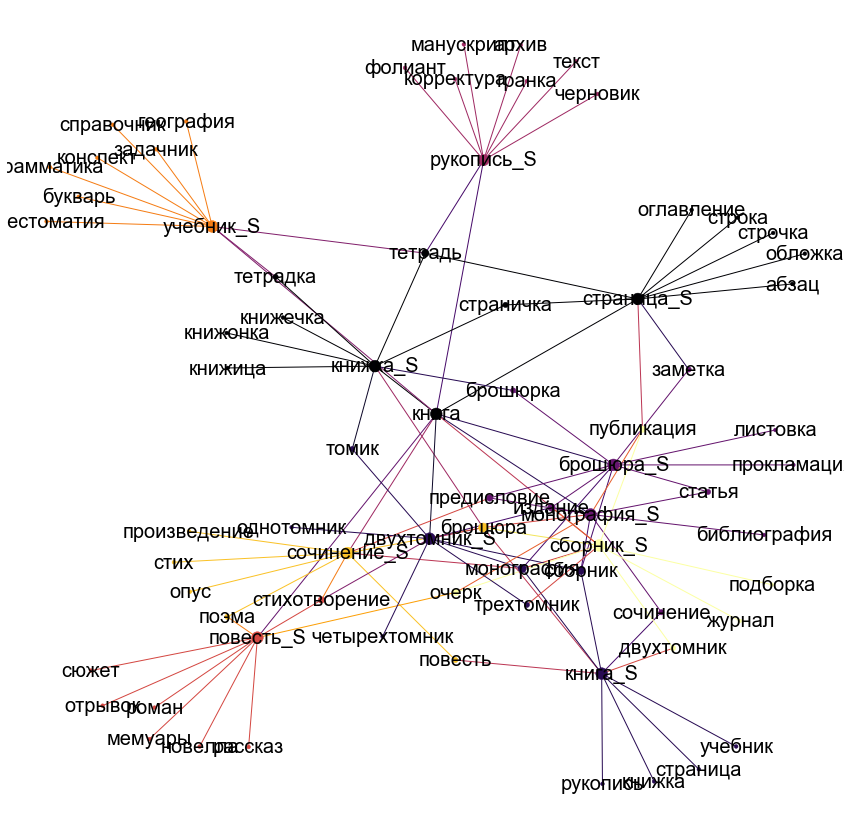

In [12]:
pos=nx.spring_layout(G, iterations=100)

cmap = plt.get_cmap('inferno')

plt.figure(figsize=(15, 15))
nx.draw_networkx_nodes(G, pos, cmap = cmap,
                       node_color = node_color,
                       node_size=node_size) 
nx.draw_networkx_edges(G, pos, edge_cmap=cmap, edge_color=edge_color)
nx.draw_networkx_labels(G, pos, font_size=20, font_family='Arial')
plt.axis('off') 
plt.show()

__Пояснение по визуализации:__
* Цвет обозначает принадлежность какому-либо найденному сообществу
* Толщина узлов пропорциональна их центральности